In [11]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from read_data import read_raster
from GPC_main_op import gpcmain
import matplotlib as plt

import os
print(os.getcwd())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
C:\Users\User\zzp_research\GPC_figshare\GPC_Code


In [3]:
def nanline(xMatrix):
    xMatrix[xMatrix < -1e+38] = np.nan
    valid_row_mask = ~np.isnan(xMatrix).all(axis=1)
    valid_col_mask = ~np.isnan(xMatrix).all(axis=0)
    xMatrix= xMatrix[valid_row_mask][:, valid_col_mask]
    return xMatrix
    

In [10]:
# path 
x_path = "../GPC_data/Case2/NDVI_202104_06_1000.tif"
y_path = "../GPC_data/Case2/LST_202104_06.tif"
lag=7
E=5
tau=1
verbose=True
metric="euclidean"  #"euclidean", "manhattan", "chebyshev"]

xMatrix, xtransform, xmeta = read_raster(x_path)
yMatrix, ytransform, ymeta = read_raster(y_path)



In [6]:
xMatrix=nanline(xMatrix)
yMatrix=nanline(yMatrix)
xMatrix= np.nan_to_num(xMatrix, nan=0.00001)
yMatrix = np.nan_to_num(yMatrix, nan=0.00001)


In [8]:
summary_x_map_y,summary_y_map_x=gpcmain(xMatrix,
    yMatrix,
    E=3,
    tau=4,
    lag=2*E+1,
    metric="euclidean",
    weighted = True,
    verbose= True)

Computing M for matrix of shape (150302, 4)
signaturespace matrix of shape (150302, 3)
patternspace matrix of shape (150302, 1)
Computing M for matrix of shape (150302, 4)
signaturespace matrix of shape (150302, 3)
patternspace matrix of shape (150302, 1)
[KNN] Computing top-4 euclidean distances for matrix of shape (150302, 4)


KNN 批处理: 100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:03<00:00,  4.15it/s]


Parameter：
E=: 3
metric=: euclidean
y->x causality type: negative
y->x causality strenght： 0.3778751586075118
Computing M for matrix of shape (150302, 4)
signaturespace matrix of shape (150302, 3)
patternspace matrix of shape (150302, 1)
Computing M for matrix of shape (150302, 4)
signaturespace matrix of shape (150302, 3)
patternspace matrix of shape (150302, 1)
[KNN] Computing top-4 euclidean distances for matrix of shape (150302, 4)


KNN 批处理: 100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.98it/s]


x->y causality type: negative
x->y causality strenght： 0.28758803772681796


# pearsonr and LiNGAM


In [13]:
from scipy.stats import pearsonr
import numpy as np
from lingam import DirectLiNGAM


In [14]:
x = xMatrix.flatten()
y = yMatrix.flatten()

mask = ~np.isnan(x) & ~np.isnan(y)
x_clean = x[mask]
y_clean = y[mask]

r, p_value = pearsonr(x_clean, y_clean)

print(f"Pearson correlation: r = {r:.4f}, p = {p_value:.4e}")




Pearson correlation: r = 0.2458, p = 0.0000e+00


In [15]:
xMatrix=nanline(xMatrix)
yMatrix=nanline(yMatrix)
xMatrix= np.nan_to_num(xMatrix, nan=0.00001)
yMatrix = np.nan_to_num(yMatrix, nan=0.00001)

data = np.column_stack((xMatrix.flatten(), yMatrix.flatten()))

model = DirectLiNGAM()
model.fit(data)

causal_matrix = model.adjacency_matrix_

print("LiNGAM:")

print(causal_matrix)


LiNGAM:
[[0.         0.00650182]
 [0.         0.        ]]


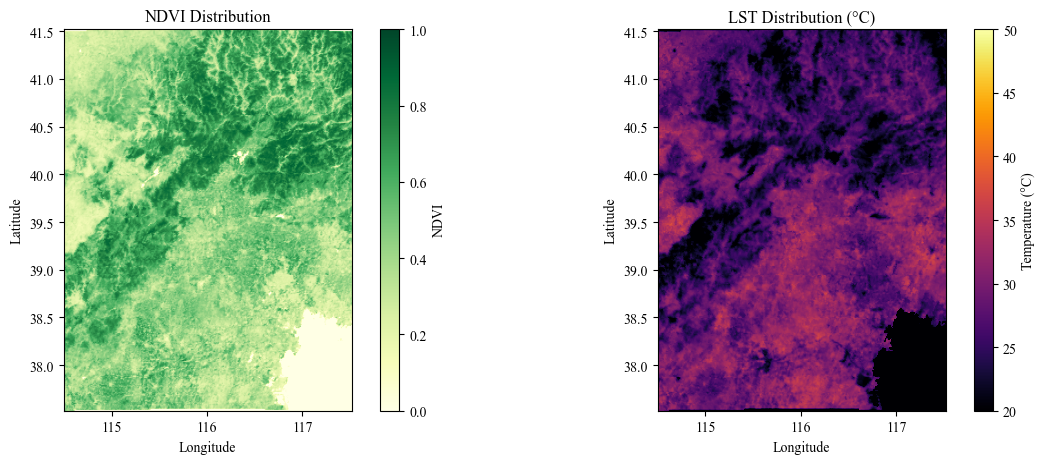

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from affine import Affine
from matplotlib import rcParams
rcParams['font.family'] = 'Times New Roman'

ndvi = xMatrix
lst = yMatrix
cols,rows=ndvi.shape
transform = Affine(0.008983152841195215, 0.0, 114.49926611387421,
                   0.0, -0.008983152841195215, 41.52013243200429)

# create grid
x_coords = np.arange(cols)
y_coords = np.arange(rows)
lon = transform.c + x_coords * transform.a
lat = transform.f + y_coords * transform.e
lat = lat[::-1]  


lon2d, lat2d = np.meshgrid(lon, lat)


fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# NDVI 
im1 = axs[0].imshow(ndvi, origin='upper',
                    extent=[lon.min(), lon.max(), lat.min(), lat.max()],
                    cmap='YlGn', vmin=0, vmax=1)
axs[0].set_title("NDVI Distribution")
axs[0].set_xlabel("Longitude")
axs[0].set_ylabel("Latitude")
plt.colorbar(im1, ax=axs[0], label='NDVI')

# LST 
im2 = axs[1].imshow(lst, origin='upper',
                    extent=[lon.min(), lon.max(), lat.min(), lat.max()],
                    cmap='inferno', vmin=20, vmax=50)
axs[1].set_title("LST Distribution (°C)")
axs[1].set_xlabel("Longitude")
axs[1].set_ylabel("Latitude")
plt.colorbar(im2, ax=axs[1], label='Temperature (°C)')

#plt.suptitle("Figure 3. Spatial Distribution of NDVI and LST in Beijing Area", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("..\ndvi_lst_distribution2.png", dpi=300, bbox_inches='tight')

plt.show()
